# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *
from modules.data_import import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [3]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [4]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [5]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [6]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

def reconvert_event(in_data):
    move_to_cartesian(in_data, 'PRI_tau', drop=False)
    move_to_cartesian(in_data, 'PRI_lep', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_leading', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_subleading', drop=False)
    move_to_cartesian(in_data, 'PRI_met', z=False)

id = 19
nom = pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]

z_flip = nom.copy()
z_flip_event(z_flip)
reconvert_event(z_flip)

rot = nom.copy()
rotate_event(rot)
reconvert_event(rot)

rot_y = nom.copy()
rotate_event(rot_y)
y_flip_event(rot_y)
reconvert_event(rot_y)

rot_yz = nom.copy()
rotate_event(rot_yz)
y_flip_event(rot_yz)
z_flip_event(rot_yz)
reconvert_event(rot_yz)

comp_events([nom, rot, rot_y, rot_yz])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


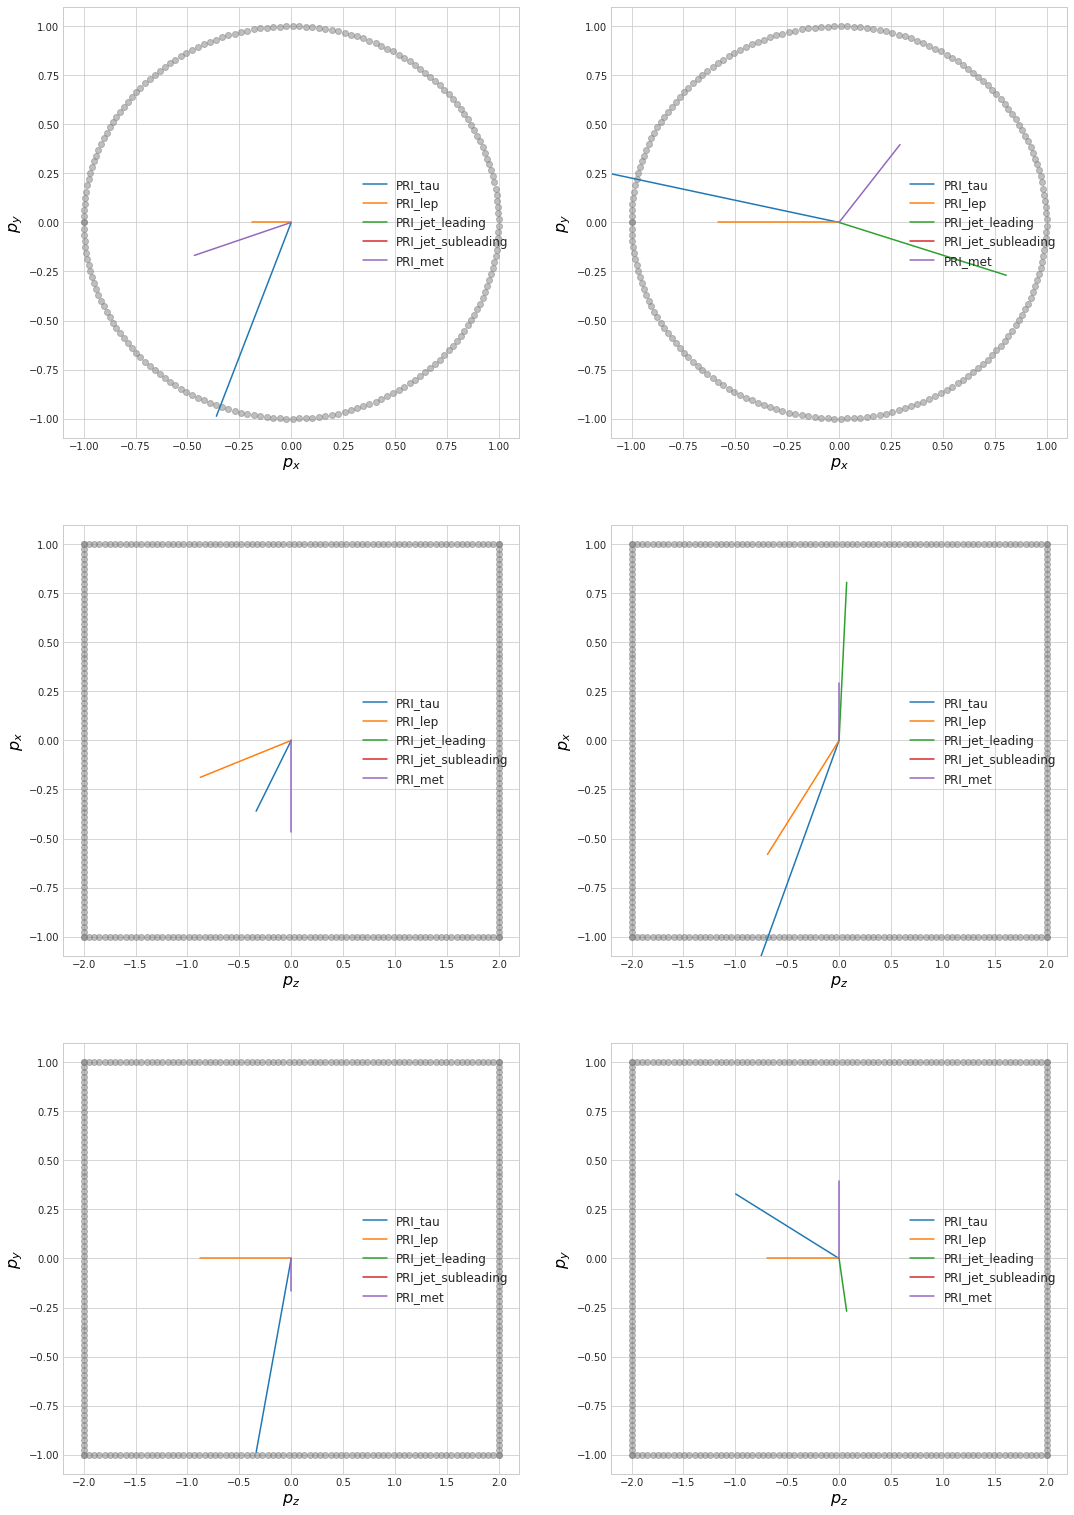

In [7]:
id = 0
pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]
comp_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1],
             pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id+1:id+2]])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.124s 


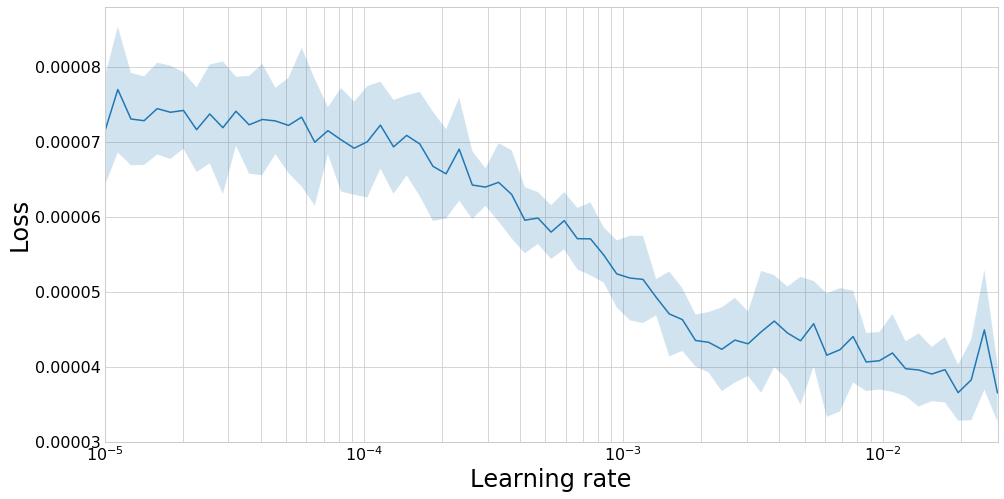

______________________________________



In [8]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [9]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [10]:
model_gen_params

{'version': 'modelSwish',
 'n_in': 30,
 'compile_args': {'loss': 'binary_crossentropy',
  'optimizer': 'adam',
  'lr': 0.002,
  'amsgrad': False,
  'beta_1': 0.9},
 'mode': 'classifier'}

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 3.682446924358373e-05
2 New best found: 3.4727641467179634e-05
3 New best found: 3.407582816143986e-05
4 New best found: 3.3907801669556645e-05
5 New best found: 3.333928888750961e-05
6 New best found: 3.304203861480346e-05
7 New best found: 3.2883152303111275e-05
9 New best found: 3.286149188425043e-05
12 New best found: 3.2368738436343844e-05
13 New best found: 3.225668676241184e-05
14 New best found: 3.217628888596664e-05
15 New best found: 3.21717976097716e-05
25 New best found: 3.211826955521247e-05
27 New best found: 3.2020857532916125e-05
29 New best found: 3.195631289854646e-05
30 New best found: 3.1913344511849574e-05
31 New best found: 3.191233285033377e-05
54 New best found: 3.185767170798499e-05
56 New best found: 3.181706657414906e-05
57 New best found: 3.177707632712554e-05
58 New best found: 3.1738986018172e-05
59 New best found: 3.17338672684

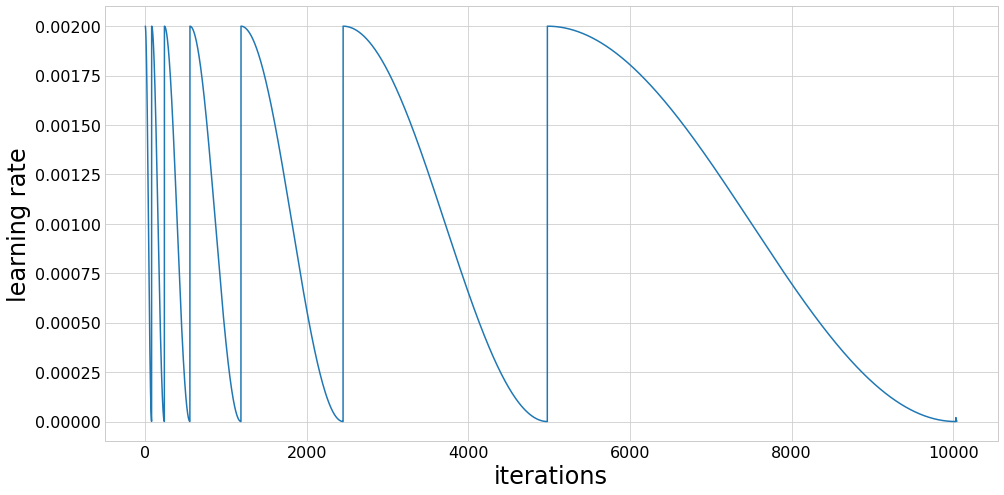

Fold took 116.407s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228811). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114840). Check your callbacks.
  % delta_t_median)


1 New best found: 3.699285999392905e-05
2 New best found: 3.459354651410475e-05
3 New best found: 3.39857464811105e-05
4 New best found: 3.376818827147629e-05
5 New best found: 3.306973398425529e-05
6 New best found: 3.2925737212148404e-05
7 New best found: 3.2784663523e-05
10 New best found: 3.2778640254759797e-05
11 New best found: 3.257026414702753e-05
12 New best found: 3.2424191561238206e-05
13 New best found: 3.2164221033098135e-05
14 New best found: 3.214386998120944e-05
15 New best found: 3.211843983562788e-05
25 New best found: 3.201812390800403e-05
26 New best found: 3.1928239132585956e-05
29 New best found: 3.185007388880939e-05
30 New best found: 3.181090776111098e-05
31 New best found: 3.180885923217865e-05
53 New best found: 3.16463510711865e-05
57 New best found: 3.1573381846625646e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00016922145506649918
Early stopping after 137 epochs
Score is: {'loss': 3.1573381846625646e-05, 'wAUC': 0.0624443094318

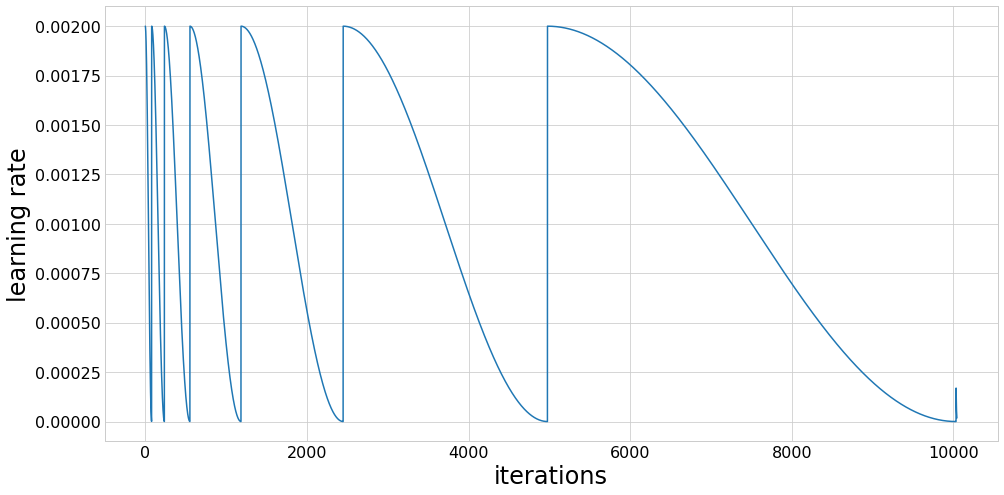

Fold took 117.781s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253627). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127198). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7407708849059416e-05
2 New best found: 3.446618935849983e-05
3 New best found: 3.400268011901062e-05
5 New best found: 3.392879836028442e-05
6 New best found: 3.2826050942821895e-05
7 New best found: 3.2731914914620575e-05
11 New best found: 3.256216572772246e-05
13 New best found: 3.219295105955098e-05
14 New best found: 3.2142564988316736e-05
15 New best found: 3.2129588870884614e-05
22 New best found: 3.205463898048038e-05
23 New best found: 3.1935215642442926e-05
25 New best found: 3.1769259607244746e-05
26 New best found: 3.171983565407572e-05
28 New best found: 3.17098404506396e-05
29 New best found: 3.164902896241983e-05
52 New best found: 3.163266420160653e-05
53 New best found: 3.1494483987626154e-05
57 New best found: 3.149374951608479e-05
58 New best found: 3.145182630905765e-05
61 New best found: 3.1443870268412866e-05
62 New best found: 3.143988212905242e-05
63 New best found: 3.143914357642643e-05
CosineAnneal stalling after 255 epochs, entering redux 

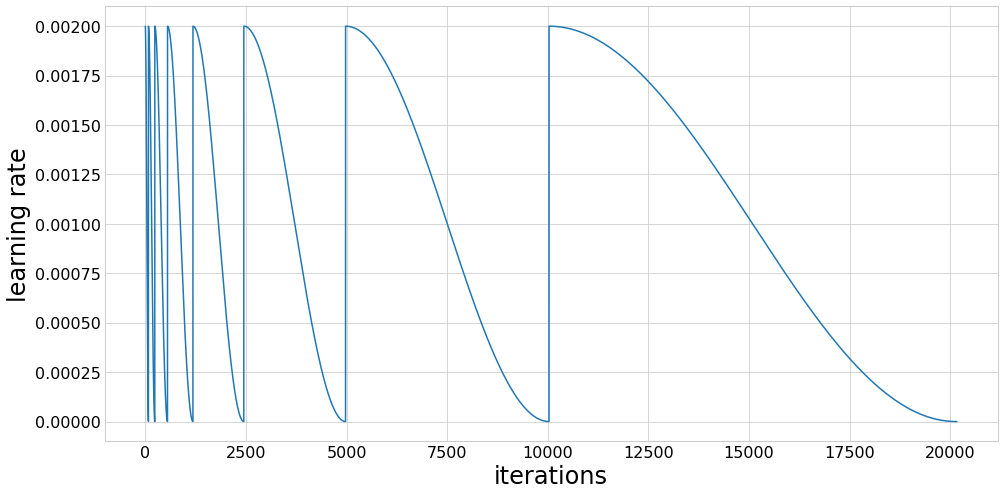

Fold took 239.971s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259173). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129959). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7108566462879205e-05
2 New best found: 3.5058761467240007e-05
3 New best found: 3.452910814206296e-05
4 New best found: 3.4397383960611945e-05
5 New best found: 3.424718374373038e-05
6 New best found: 3.334132151646519e-05
7 New best found: 3.3253989457914875e-05
9 New best found: 3.313906762110739e-05
10 New best found: 3.285116396690517e-05
13 New best found: 3.2582136265131395e-05
14 New best found: 3.24588984581596e-05
24 New best found: 3.237632718224368e-05
25 New best found: 3.2361596024979375e-05
26 New best found: 3.21714556755678e-05
27 New best found: 3.209142769153351e-05
28 New best found: 3.20845796068469e-05
29 New best found: 3.20472480945904e-05
30 New best found: 3.204287684011712e-05
31 New best found: 3.2042118868588735e-05
53 New best found: 3.1983757563073e-05
54 New best found: 3.189853313826664e-05
55 New best found: 3.185819775453798e-05
56 New best found: 3.180852093742813e-05
CosineAnneal stalling after 127 epochs, entering redux decay at 

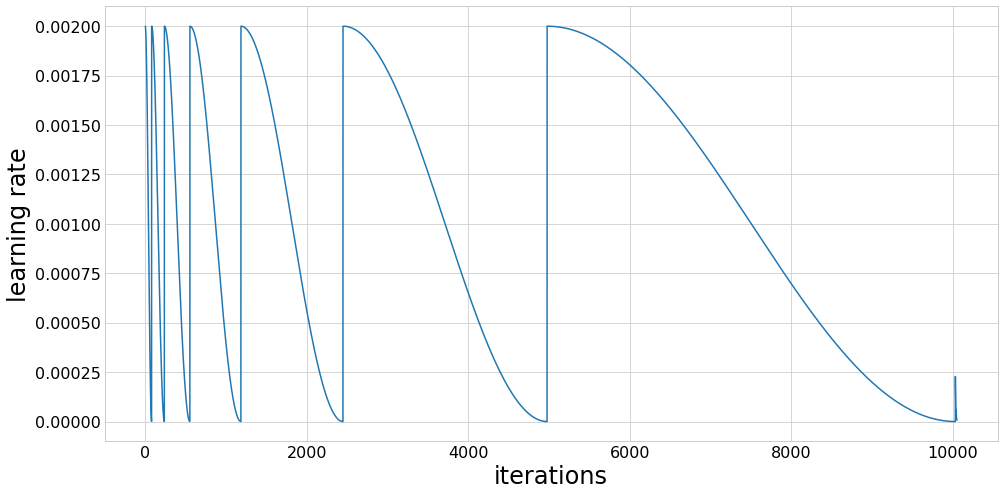

Fold took 131.753s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.294525). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147609). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7233079211434e-05
2 New best found: 3.464259797916813e-05
3 New best found: 3.4071491451596865e-05
5 New best found: 3.3366613088677264e-05
6 New best found: 3.327121674309088e-05
7 New best found: 3.313608312058432e-05
11 New best found: 3.2867193199130944e-05
12 New best found: 3.276659196171133e-05
13 New best found: 3.253356676850467e-05
14 New best found: 3.24675966976472e-05
15 New best found: 3.244681892459502e-05
26 New best found: 3.230320747335242e-05
27 New best found: 3.2239777733161395e-05
28 New best found: 3.220182708807074e-05
30 New best found: 3.2162525347330215e-05
31 New best found: 3.215950786774757e-05
49 New best found: 3.211296397572795e-05
50 New best found: 3.2023830741275834e-05
55 New best found: 3.200424288321248e-05
56 New best found: 3.198683929593888e-05
58 New best found: 3.19349405713406e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00011866523563337172
131 New best found: 3.1934853333794844e-05
Early stop

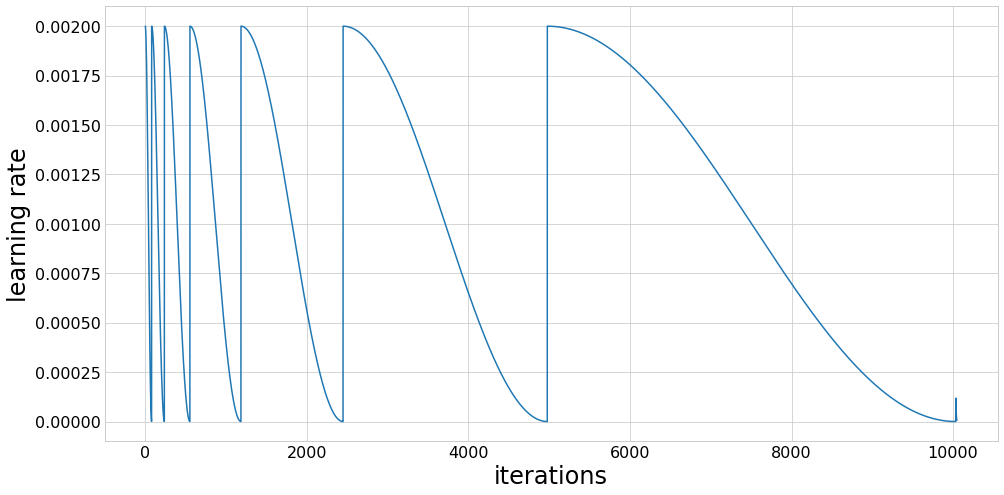

Fold took 130.497s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.324703). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162749). Check your callbacks.
  % delta_t_median)


1 New best found: 3.6540275764768265e-05
2 New best found: 3.481595592667752e-05
3 New best found: 3.4152091125875164e-05
5 New best found: 3.333787764595932e-05
6 New best found: 3.300023164158162e-05
7 New best found: 3.275011595248092e-05
11 New best found: 3.244673003077661e-05
12 New best found: 3.2239534714394386e-05
14 New best found: 3.216349319412788e-05
15 New best found: 3.213030667356141e-05
25 New best found: 3.191228050206887e-05
26 New best found: 3.1829987704968225e-05
28 New best found: 3.174477370520481e-05
29 New best found: 3.16665515369835e-05
30 New best found: 3.165891691793486e-05
31 New best found: 3.165569804460053e-05
53 New best found: 3.159173642987054e-05
56 New best found: 3.15181038440488e-05
58 New best found: 3.1517277482047e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00011866523563337172
Early stopping after 137 epochs
Score is: {'loss': 3.1517277482047e-05, 'wAUC': 0.06248684223834966, 'AUC': 0.09879099164881511, 'AMS': 3

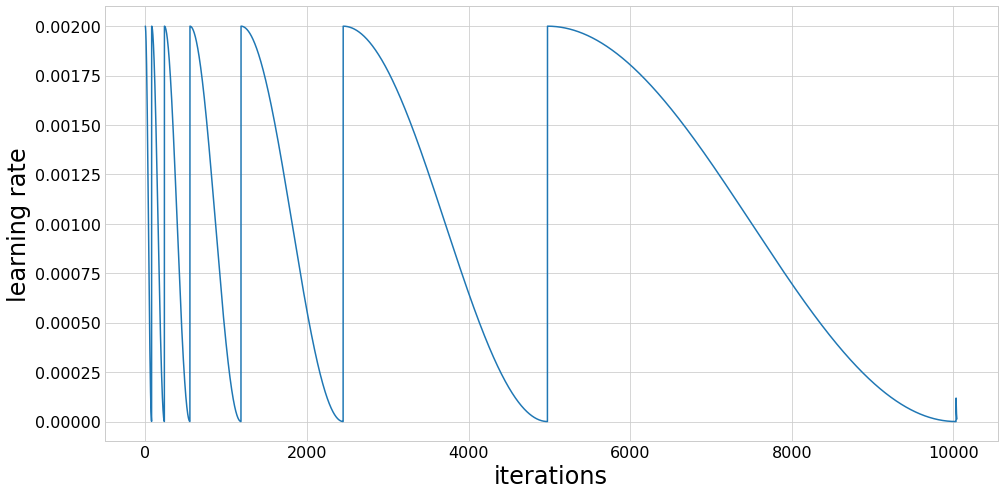

Fold took 128.956s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.333157). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167023). Check your callbacks.
  % delta_t_median)


1 New best found: 3.711511388752504e-05
2 New best found: 3.527899337802571e-05
3 New best found: 3.464899415048236e-05
4 New best found: 3.4626846274118704e-05
5 New best found: 3.436915904740133e-05
6 New best found: 3.3653978541439174e-05
7 New best found: 3.342751811073187e-05
10 New best found: 3.3059446106444824e-05
12 New best found: 3.2803154441432344e-05
13 New best found: 3.2796133663865e-05
14 New best found: 3.267271126378298e-05
15 New best found: 3.265489609229722e-05
23 New best found: 3.261280188029931e-05
25 New best found: 3.236503444476081e-05
28 New best found: 3.232901414134917e-05
29 New best found: 3.2230948634732983e-05
30 New best found: 3.2209055750868985e-05
48 New best found: 3.21982880899736e-05
50 New best found: 3.211840542972985e-05
56 New best found: 3.200757168075324e-05
57 New best found: 3.2001955944118535e-05
59 New best found: 3.197410815590525e-05
60 New best found: 3.197193942629209e-05
61 New best found: 3.1962774403205566e-05
62 New best found:

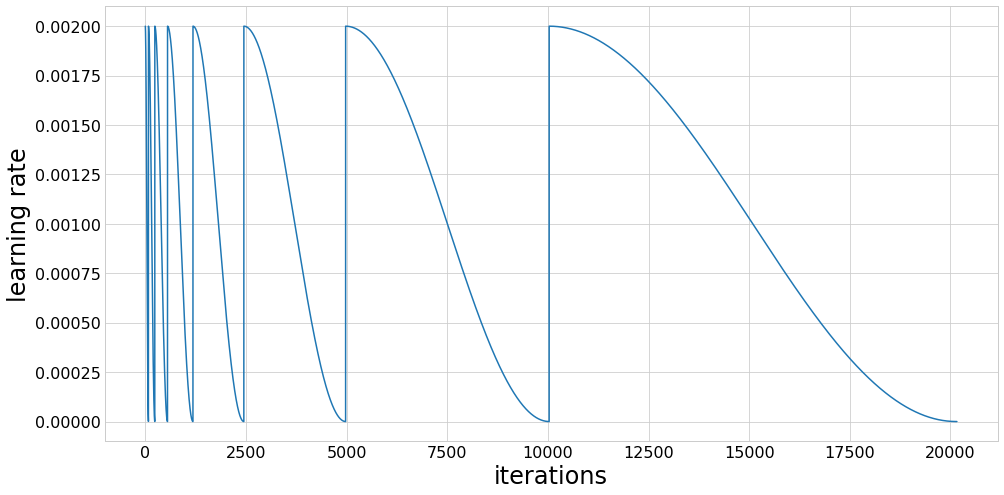

Fold took 259.802s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.367799). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184295). Check your callbacks.
  % delta_t_median)


1 New best found: 3.58004220033763e-05
2 New best found: 3.404661002423382e-05
3 New best found: 3.357987416384276e-05
5 New best found: 3.308553794850013e-05
6 New best found: 3.257441208552336e-05
7 New best found: 3.244732769744587e-05
11 New best found: 3.220352751013706e-05
12 New best found: 3.209866210818291e-05
13 New best found: 3.179222431353992e-05
15 New best found: 3.178177632944426e-05
24 New best found: 3.176954895097879e-05
25 New best found: 3.167665550572565e-05
27 New best found: 3.153746270036209e-05
28 New best found: 3.1516136333812025e-05
29 New best found: 3.142772172868717e-05
30 New best found: 3.142512341582915e-05
31 New best found: 3.142155651876237e-05
47 New best found: 3.141578534050495e-05
49 New best found: 3.138185811258154e-05
53 New best found: 3.1362700631143525e-05
56 New best found: 3.119450446829433e-05
57 New best found: 3.11806750803953e-05
58 New best found: 3.11309297583648e-05
61 New best found: 3.112406755317352e-05
CosineAnneal stalling a

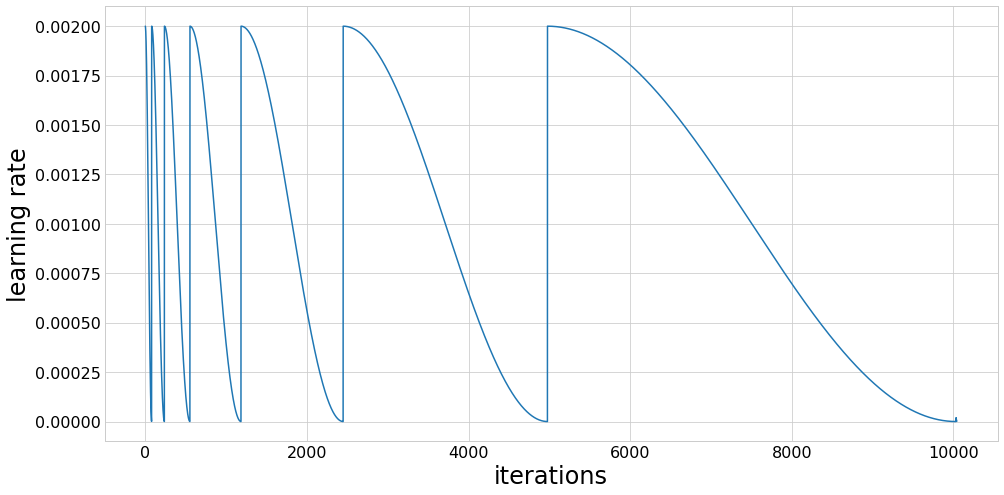

Fold took 138.533s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.388108). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194468). Check your callbacks.
  % delta_t_median)


1 New best found: 3.837807349336799e-05
2 New best found: 3.56772115585045e-05
3 New best found: 3.539884690399049e-05
4 New best found: 3.4745091325748945e-05
5 New best found: 3.410048655641731e-05
6 New best found: 3.375681799661834e-05
7 New best found: 3.36220594443148e-05
10 New best found: 3.3400549866928485e-05
11 New best found: 3.3173112040094564e-05
12 New best found: 3.300165868568001e-05
14 New best found: 3.2851414132164794e-05
15 New best found: 3.2825342343130615e-05
26 New best found: 3.2683914462540995e-05
27 New best found: 3.251196536803036e-05
28 New best found: 3.2480018819478576e-05
29 New best found: 3.2433992403821324e-05
55 New best found: 3.241428997935145e-05
56 New best found: 3.227404149802169e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00022777852649451198
Early stopping after 137 epochs
Score is: {'loss': 3.227404149802169e-05, 'wAUC': 0.06582282438968101, 'AUC': 0.10083064614723569, 'AMS': 3.8417071710179904, 'cut': 0.976241

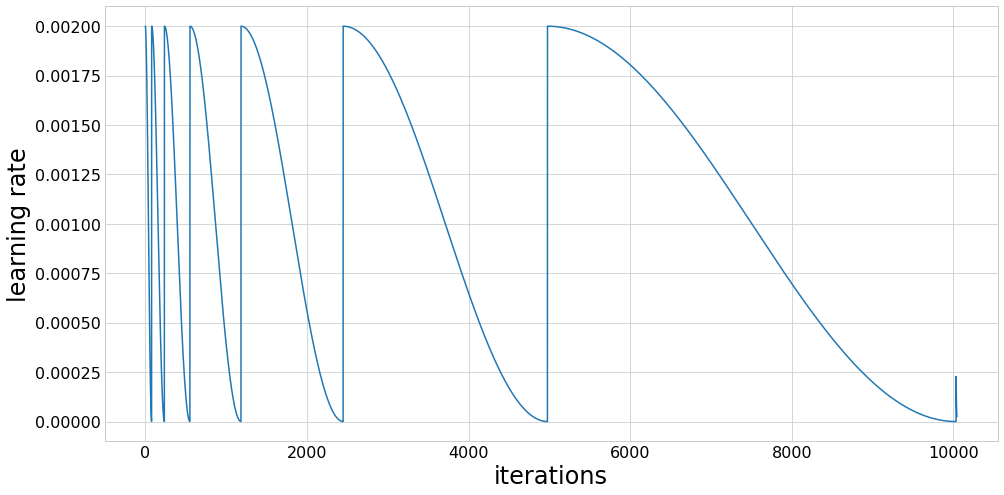

Fold took 142.174s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.404755). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202752). Check your callbacks.
  % delta_t_median)


1 New best found: 3.6794271450865116e-05
2 New best found: 3.450479768078985e-05
3 New best found: 3.3926056248230134e-05
5 New best found: 3.350916102226934e-05
6 New best found: 3.3040959625239984e-05
7 New best found: 3.280062355438548e-05
11 New best found: 3.2722401792252785e-05
12 New best found: 3.247413381977882e-05
13 New best found: 3.239694998154804e-05
14 New best found: 3.231383816435369e-05
15 New best found: 3.2269495683415184e-05
24 New best found: 3.2215510751027954e-05
25 New best found: 3.2016550623589326e-05
26 New best found: 3.197439575070375e-05
29 New best found: 3.1923278166884017e-05
30 New best found: 3.187726388816001e-05
31 New best found: 3.1876639956213406e-05
47 New best found: 3.1815816160871985e-05
51 New best found: 3.178581540599284e-05
52 New best found: 3.170516082971663e-05
56 New best found: 3.170191146535768e-05
57 New best found: 3.162344244859719e-05
58 New best found: 3.1621515421942635e-05
60 New best found: 3.161737828175157e-05
61 New best

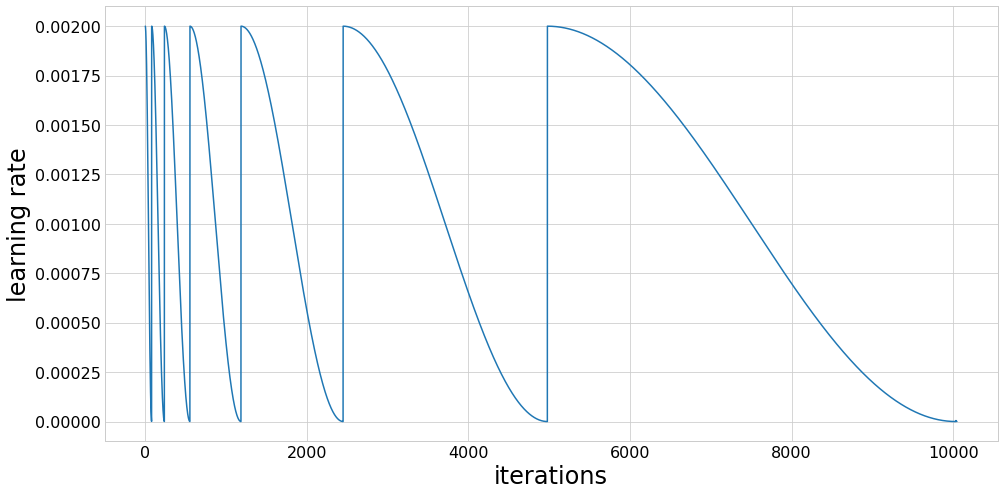

Fold took 145.896s


______________________________________
Training finished
Cross-validation took 1554.654s 


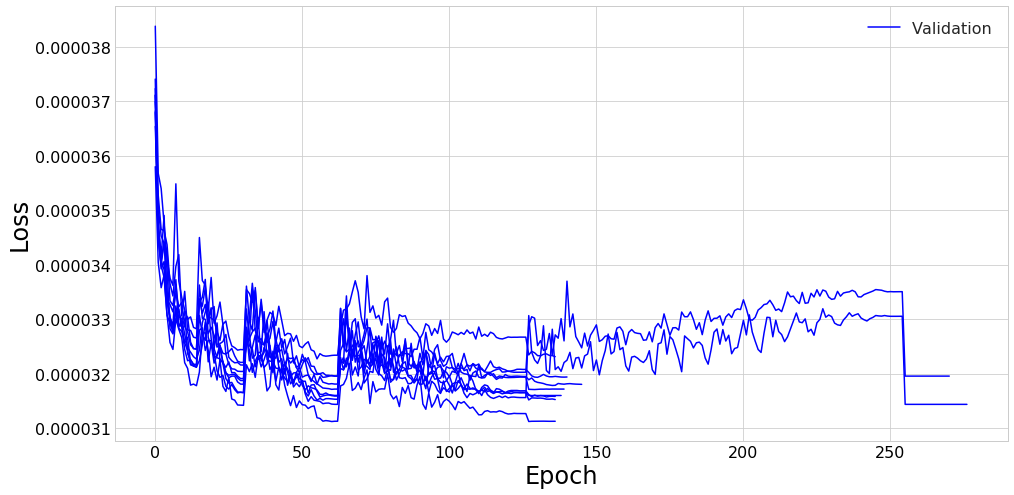

Mean loss = 3.169e-05 +- 1e-07
Mean wAUC = 0.063 +- 0.0004
Mean AUC = 0.0983 +- 0.0005
Mean AMS = 3.87 +- 0.05
Mean cut = 0.957 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [11]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [12]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [13]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 7 with loss = 3.112406755317352e-05
Model 1 is 2 with loss = 3.143914348329418e-05
Model 2 is 5 with loss = 3.1517277482047e-05
Model 3 is 1 with loss = 3.1573381846625646e-05
Model 4 is 9 with loss = 3.1600859612636697e-05
Model 5 is 0 with loss = 3.171105400469969e-05
Model 6 is 3 with loss = 3.178597976305654e-05
Model 7 is 4 with loss = 3.1934853333794844e-05
Model 8 is 6 with loss = 3.195749950893081e-05
Model 9 is 8 with loss = 3.227404149802169e-05


## Response on validation data without TTA

In [14]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [15]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001773128431290388s per sample

Predicting fold 2 out of 10
Prediction took 0.00039097068384289743s per sample

Predicting fold 3 out of 10
Prediction took 0.0003929369118064642s per sample

Predicting fold 4 out of 10
Prediction took 0.00039743170626461505s per sample

Predicting fold 5 out of 10
Prediction took 0.00039569725692272184s per sample

Predicting fold 6 out of 10
Prediction took 0.0003978977955877781s per sample

Predicting fold 7 out of 10
Prediction took 0.0003928279407322407s per sample

Predicting fold 8 out of 10
Prediction took 0.00039218767918646337s per sample

Predicting fold 9 out of 10
Prediction took 0.0003944753926247358s per sample

Predicting fold 10 out of 10
Prediction took 0.0004003286115825176s per sample



In [16]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [17]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9036066830656907, weighted 0.9360072140529891


Best cut at 0.9637295891334106 corresponds to AMS of 3.8428705175226017
Maximum AMS for data is 3.884805073720649 at cut of 0.965740442276001
CPU times: user 26.2 s, sys: 2.02 ms, total: 26.2 s
Wall time: 26.2 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


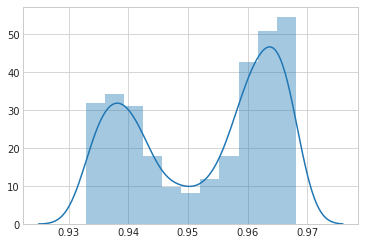

In [18]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9527296 corresponds to AMS of 3.7475339265982828
Maximum AMS for data is 3.884805073720649 at cut of 0.965740442276001
CPU times: user 92.6 ms, sys: 33.2 ms, total: 126 ms
Wall time: 81.3 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


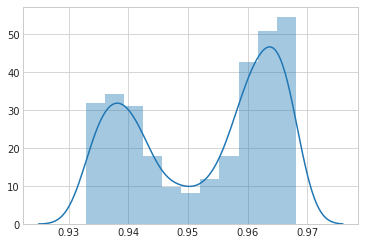

In [19]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [20]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [21]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00039225757782432167s per sample

Predicting fold 2 out of 10
Prediction took 0.00039247397672046314s per sample

Predicting fold 3 out of 10
Prediction took 0.00039486908949911597s per sample

Predicting fold 4 out of 10
Prediction took 0.0003921099720014767s per sample

Predicting fold 5 out of 10
Prediction took 0.00039507637816396624s per sample

Predicting fold 6 out of 10
Prediction took 0.00039200128879059447s per sample

Predicting fold 7 out of 10
Prediction took 0.0003899393483996391s per sample

Predicting fold 8 out of 10
Prediction took 0.00039122274057431654s per sample

Predicting fold 9 out of 10
Prediction took 0.00039155961180275135s per sample

Predicting fold 10 out of 10
Prediction took 0.0003920806165107272s per sample

CPU times: user 3min 56s, sys: 5.95 s, total: 4min 1s
Wall time: 3min 35s


In [22]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.6174623982159764 : 3.697934539214916


(3.6174623982159764, 3.697934539214916)

In [23]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.7136952030034944 : 3.7525976897143734


(3.7136952030034944, 3.7525976897143734)

# Save/Load

In [1]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)